In [1]:
from pathlib import Path
import json
import rich
import yaml
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
sns.set_theme()
tokenizer = transformers.GPT2TokenizerFast.from_pretrained('gpt2')

formatters = {
    'accuracy': '{:,.1%}'.format,
    'f1': '{:,.1%}'.format,
    'precision': '{:,.1%}'.format,
    'n_tokens': '{:,.0f}'.format,
}

multirun_path = Path("/home/valv/remote_data/14-16-28")
# multirun_path = Path("/home/valv/remote_data/11-28-48")

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
summary = []
records = []
glob_keys = ['strategy']
local_keys = ['labels', 'predictions']
series = {}
lengths = []

sorted_exp_paths = []
for exp in multirun_path.iterdir():
    if exp.is_dir():
        data_file = exp / 'data.json'
        if not data_file.exists():
            continue
        exp_data = json.load(open(data_file, 'r'))
        sorted_exp_paths.append((exp, exp_data['accuracy']))
sorted_exp_paths = [x[0] for x in sorted(sorted_exp_paths, key=lambda x: -x[1])]
for exp in sorted_exp_paths:
        data_file = exp / 'data.json'
        config_file = exp / 'config.yaml'
        exp_data = json.load(open(data_file, 'r'))
        cfg = yaml.safe_load(open(config_file, 'r'))
        exp_data['strategy'] = exp_data['strategy'].split('+')[0]
        if 'prompt_style' in cfg.keys():
            exp_data['strategy'] = f"{cfg['prompt_style']}-{exp_data['strategy']}"
        # infer the length
        n_tokens = []
        for txt_file in (exp / 'output').iterdir():
            if txt_file.name.endswith('.txt'):
                with open(txt_file, 'r') as f:
                    content = f.read()
                    reasoning = content.split(exp_data['strategy'])[-1]
                    reasoning = reasoning.split('Therefore, among A through D, the answer')[0]
                n_tokens.append(len(tokenizer.encode(reasoning)))
        exp_data['n_tokens'] = np.mean(n_tokens)
        
        
        summary.append(exp_data)
        
        # register the predictions for each strategy
        series[exp_data['strategy']] = exp_data['predictions']
        
        # read all individual records
        for i in range(len(exp_data['predictions'])):
            record = {k: exp_data[k][i] for k in local_keys}
            record.update({k:v for k,v in exp_data.items() if k in glob_keys})
            record['qid'] = i
            records.append(record)

summary = pd.DataFrame(summary)
summary.index += 1 
records = pd.DataFrame(records)
series = pd.DataFrame(series)
# write the summary to file
with pd.option_context("max_colwidth", 1000):
    summary.to_latex(buf=multirun_path / 'summary.tex',
    columns=['strategy', 'accuracy', 'f1', 'n_tokens'],
    float_format="%.2f",
    formatters=formatters,
    index=True)
summary[['engine', 'strategy', 'n_samples', 'split', 'accuracy', 'f1']]

Token indices sequence length is longer than the specified maximum sequence length for this model (1062 > 1024). Running this sequence through the model will result in indexing errors
/tmp/ipykernel_76287/876272977.py:55: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  summary.to_latex(buf=multirun_path / 'summary.tex',


,engine,strategy,n_samples,split,accuracy,f1
1,text-davinci-002,short-Let's think step by step using deductive...,100,validation,0.47,0.464461
2,text-davinci-002,none-Let's think step by step using deductive ...,100,validation,0.45,0.452766
3,text-davinci-002,full-Let's think step by step like a medical e...,100,validation,0.45,0.445933
4,text-davinci-002,none-Let's think step by step like a medical e...,100,validation,0.44,0.439738
5,text-davinci-002,short-Let's think step by step like a medical ...,100,validation,0.43,0.428358
6,text-davinci-002,full-Let's think step by step using deductive ...,100,validation,0.43,0.433600


In [3]:
## Aggreement matrix

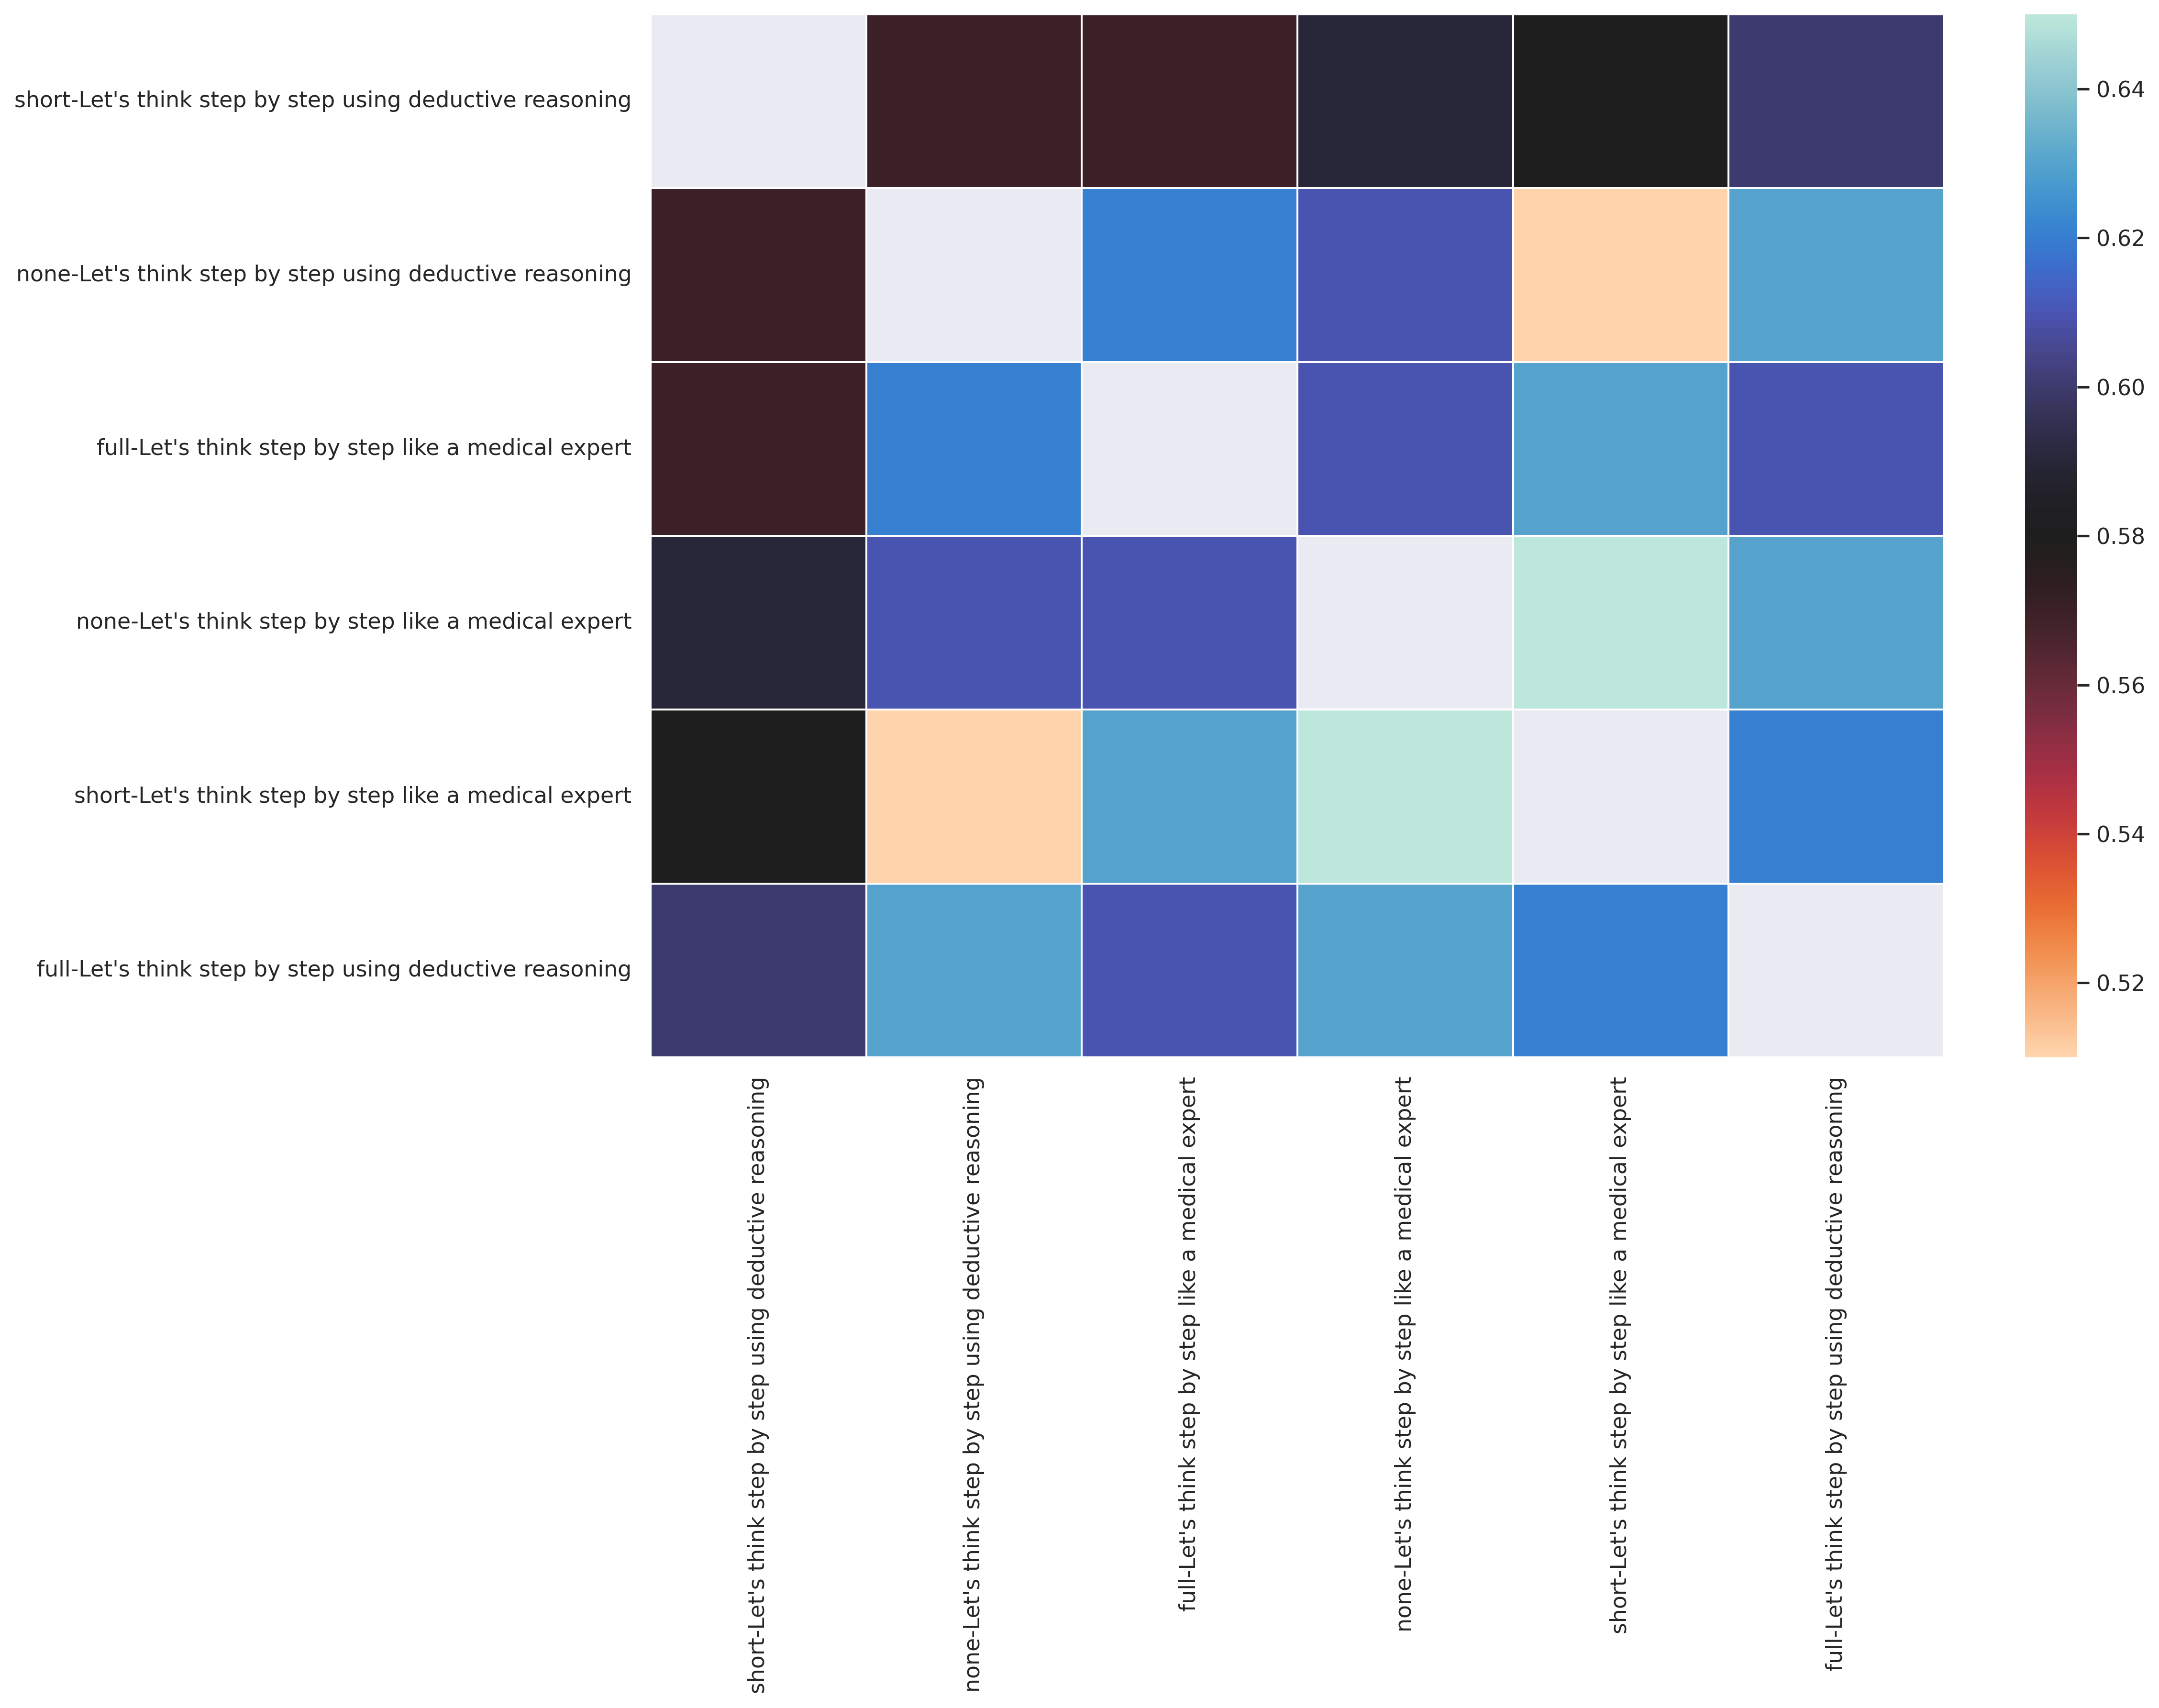

In [4]:
N = len(summary)
X = np.zeros((N, N))
# diagonal
for i in range(N):
    row = summary.iloc[i]
    acc = accuracy_score(row['labels'], row['predictions'])
    X[i, i] = np.nan

# top-diagonal: % of aggreement on correct answers
for i in range(N):
    for j in range(N):
        if j > i:
            row_i = summary.iloc[i]
            row_j = summary.iloc[j]
            assert row_i['labels'] == row_j['labels']
            labels = row_i['labels']
            y_i = row_i['predictions']
            y_j = row_j['predictions']
            # filter the correct results
            # y_i = [t for t,l in zip(y_i, labels) if t ==l]
            # y_j = [t for t,l in zip(y_j, labels) if t ==l]
            agg = sum(1 for t_i, t_j in zip(y_i, y_j) if t_i == t_j) / len(y_i)
            # register
            X[i, j] = agg
# bottom-diagonal: % of aggreement on wrong answers
for i in range(N):
    for j in range(N):
        if j < i:
            row_i = summary.iloc[i]
            row_j = summary.iloc[j]
            assert row_i['labels'] == row_j['labels']
            labels = row_i['labels']
            y_i = row_i['predictions']
            y_j = row_j['predictions']
            # filter the correct results
            # y_i = [t for t,l in zip(y_i, labels) if t != l]
            # y_j = [t for t,l in zip(y_j, labels) if t != l]
            agg = sum(1 for t_i, t_j in zip(y_i, y_j) if t_i == t_j) / len(y_i)
            # register
            X[i, j] = agg


fig, ax= plt.subplots(figsize=((16, 12)), dpi=300)
sns.heatmap(X,
            annot=False,
            fmt='g',
            ax=ax,
            xticklabels=summary['strategy'],
            yticklabels=summary['strategy'],
            linewidths=.5,
            # center=0.25,
            cmap=sns.cm.icefire_r,
           )
plt.tight_layout()
plt.savefig(multirun_path / 'expert-agreement.png', dpi=300)
plt.show()

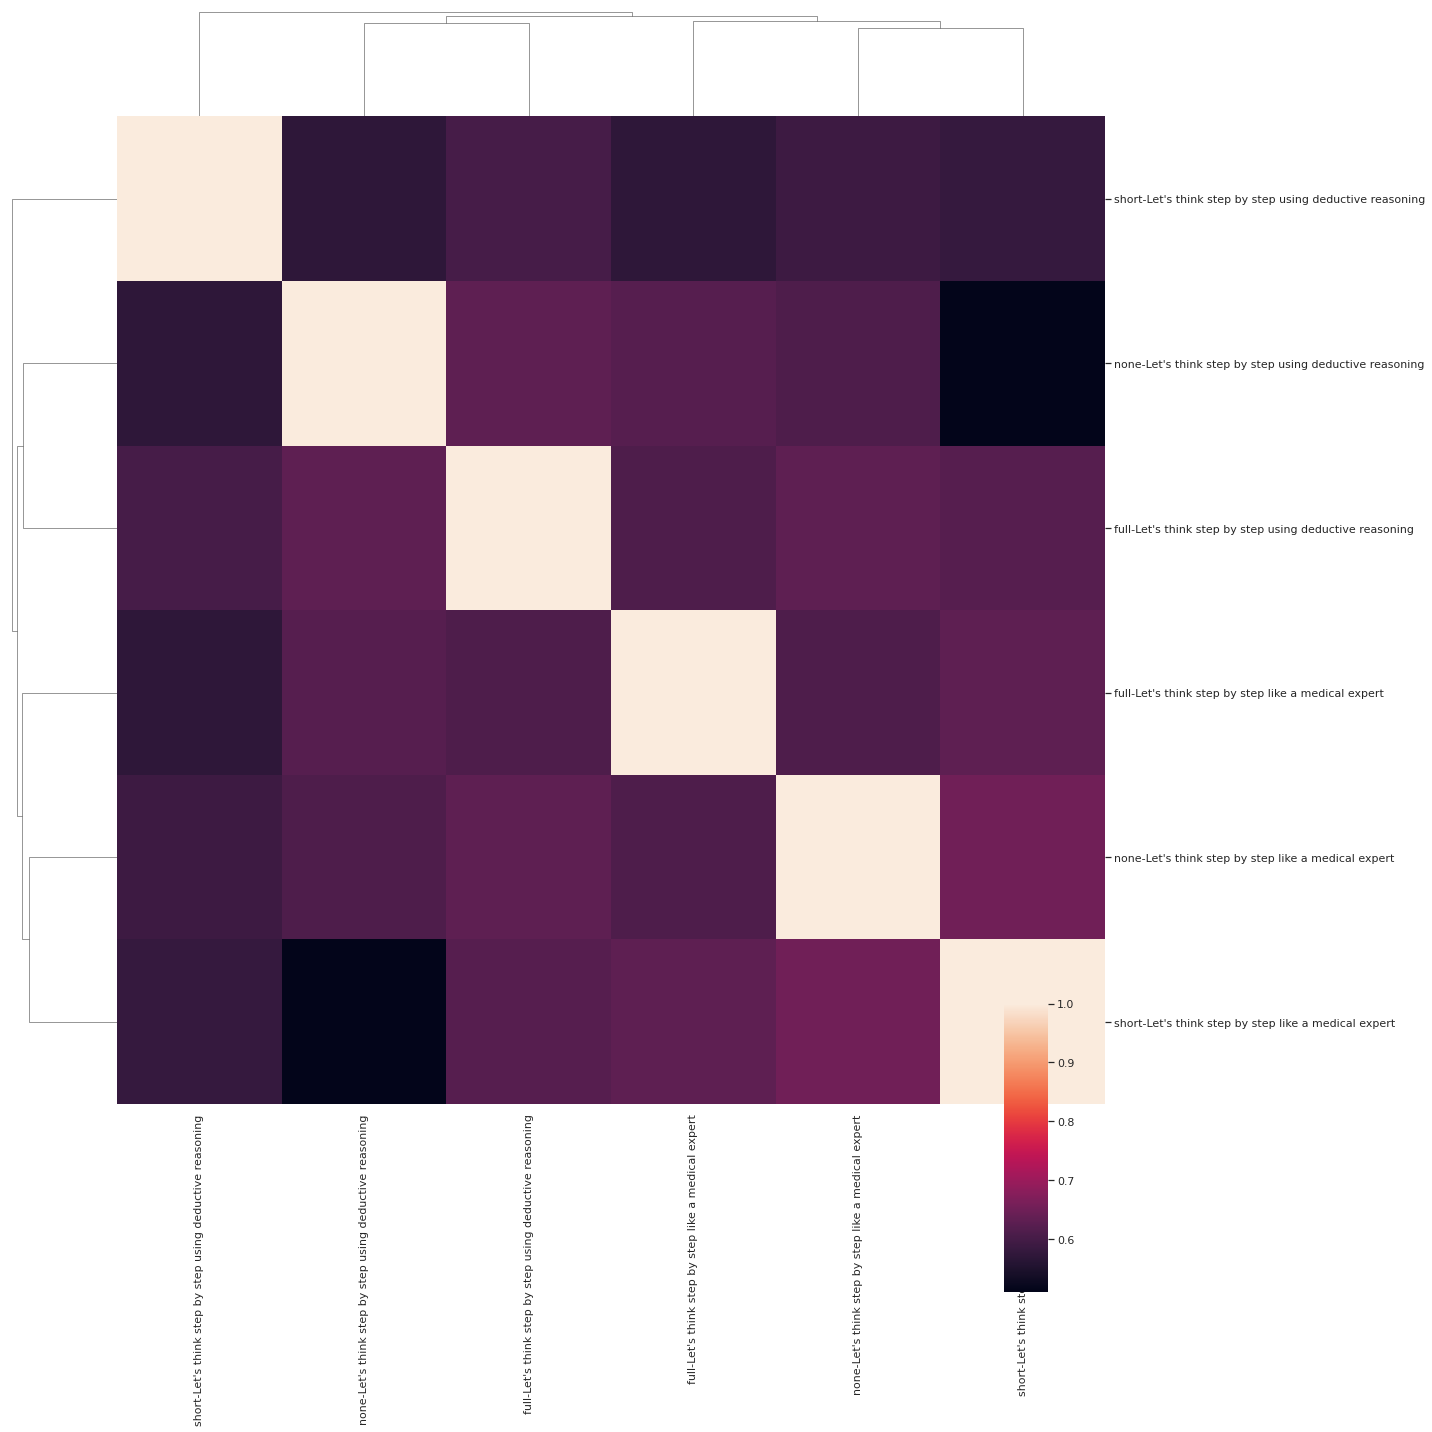

In [8]:
from sklearn.metrics.pairwise import pairwise_distances
df = series
jac_sim = 1 - pairwise_distances(df.T, metric = "hamming")
# optionally convert it to a DataFrame
jac_sim = pd.DataFrame(jac_sim, index=df.columns, columns=df.columns)

g = sns.clustermap(jac_sim,
                   # metric='matching', 
                   dendrogram_ratio=(.1, .1),
                   cbar_pos=(0.7, 0.1, .03, .2),
                   figsize=(20,20),
                   # cmap=sns.cubehelix_palette(as_cmap=True, reverse=False)
                  )
plt.savefig(multirun_path / 'cluster.png')
plt.show()

## Expert Model

In [9]:
from collections import Counter

def get_first(serie):
    x = serie.values[0]
    assert all(x == y for y in serie.values)
    return x
    
def majority_vote(serie):
    freqs = Counter(serie.values)
    return freqs.most_common(1)[0][0]



ranked_strategies = summary.sort_values('accuracy', ascending=False)['strategy'].values.tolist()
# rich.print(ranked_strategies)
# ranked_strategies = ranked_strategies[:1] + ranked_strategies[3:]
expert_data = []

def get_majority_perfs(selected_strategies):
    records_ = records[records['strategy'].isin(selected_strategies)]
    expert = records_[['labels', 'predictions', 'qid']].groupby('qid')
    expert = expert.agg(
        {'labels': get_first,
         'predictions': majority_vote,
         })
    acc = accuracy_score(expert['labels'], expert['predictions'])
    prec = precision_score(expert['labels'], expert['predictions'], average='macro')
    f1 = f1_score(expert['labels'], expert['predictions'], average='macro')
    return {'n_experts' : len(selected_strategies), 'accuracy': acc, 'precision': prec, 'f1': f1}

for top_n in [len(ranked_strategies), 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    selected_strategies = ranked_strategies[:top_n]
    output = get_majority_perfs(selected_strategies)
    expert_data.append(output)
    
expert_data = pd.DataFrame(expert_data).sort_values('n_experts', ascending=True)
with pd.option_context("max_colwidth", 1000):
    expert_data.to_latex(buf=multirun_path / 'experts.tex',
    columns=['n_experts', 'accuracy', 'f1', 'precision'],
    formatters=formatters,
    index=False)
expert_data

/tmp/ipykernel_76287/1647834339.py:38: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  expert_data.to_latex(buf=multirun_path / 'experts.tex',


,n_experts,accuracy,precision,f1
1,1,0.47,0.478207,0.464461
2,2,0.47,0.478207,0.464461
3,3,0.51,0.513064,0.507417
4,4,0.47,0.479406,0.467855
5,5,0.47,0.491279,0.468981
0,6,0.51,0.533249,0.512929
6,6,0.51,0.533249,0.512929
7,6,0.51,0.533249,0.512929
8,6,0.51,0.533249,0.512929
9,6,0.51,0.533249,0.512929


In [14]:
from tqdm import tqdm


import itertools
all_strategies = summary.sort_values('accuracy', ascending=False)['strategy'].values.tolist()
def get_permuations(budget):
    return itertools.permutations(all_strategies, budget)
expert_data = []
max_acc = 0
best_strategies = None
for budget in [2, 3, 4, 5]:
    idx = 0
    total = sum(1 for _ in get_permuations(budget))
    for perm_strategies in (pbar := tqdm(get_permuations(budget), total=total)):
        output = get_majority_perfs(perm_strategies)
        output["idx"] = idx
        expert_data.append(output)
        if output["accuracy"] > max_acc:
            max_acc = output["accuracy"]
            best_strategies = perm_strategies
            pbar.set_description(f"Budget={budget} (Best: {max_acc:.2f}, n={len(best_strategies)})")
        idx += 1
expert_data = pd.DataFrame(expert_data).sort_values('accuracy', ascending=False)
with pd.option_context("max_colwidth", 1000):
    expert_data.to_latex(buf=multirun_path / 'perm-experts.tex',
    columns=['n_experts', 'accuracy', 'f1', 'precision'],
    formatters=formatters,
    index=False)

print(f'Best strategies: {best_strategies} (Accuracy: {max_acc:.2%})')
expert_data

100%|██████████| 720/720 [00:04<00:00, 150.90it/s]

Best strategies: ("short-Let's think step by step using deductive reasoning", "none-Let's think step by step using deductive reasoning", "full-Let's think step by step like a medical expert") (Accuracy: 51.00%)



/tmp/ipykernel_76287/1065014666.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  expert_data.to_latex(buf=multirun_path / 'perm-experts.tex',


,n_experts,accuracy,precision,f1,idx
34,3,0.51,0.513064,0.507417,4
70,3,0.51,0.513064,0.507417,40
50,3,0.51,0.513064,0.507417,20
54,3,0.51,0.513064,0.507417,24
74,3,0.51,0.513064,0.507417,44
...,...,...,...,...,...
108,3,0.43,0.452840,0.431657,78
105,3,0.43,0.442993,0.431072,75
88,3,0.43,0.452840,0.431657,58
81,3,0.43,0.452840,0.431657,51
